# Introdução

O projeto, da unidade curricular de Inteligência Artificial da Licenciatura em Engenharia de Sistemas Informáticos (2024-25), tem como objetivo o desenvolvimento de um agente inteligente. Este agente será criado e implementado com base nos princípios da Inteligência Artificial, documentando todo o processo num caderno de notas Jupyter.

O trabalho foi realizado pelos seguintes membros:

- João Ponte - 17694
- João Carvalho - 12747

Este projeto procura implementar a resolução de problemas de planeamento de tarefas, abordando restrições fortes e leves, bem como estratégias para a otimização e viabilidade das soluções propostas.

# Instalar dependencias

In [1]:
!pip install networkx
!pip install matplotlib
!pip install python-constraint

# Importar bibliotecas

In [2]:
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from itertools import count

# Planeamento e Resolução do Problema
## Objetivo Geral
Resolver o problema de planeamento de tarefas descrito no ficheiro **p01_dataset_8.txt**, respeitando:
- **Restrições de precedência**: As tarefas devem ser executadas na ordem correta.
- **Disponibilidade de recursos**: Garantir que os recursos disponíveis não sejam ultrapassados.
- **Horizonte de tempo**: O cronograma deve caber dentro do limite de tempo definido.


# Carregar e ler o ficheiro p01_dataset_8.txt

In [3]:
# Caminhos dos ficheiros
dataset_path = '/app/datasets/p01_dataset_10.txt'

# Função para ler e processar os ficheiros
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    return data

# Ler o dataset
dataset = read_dataset(dataset_path)

## Passo 1: Analisar e Compreender o Ficheiro
### Estrutura do ficheiro:
1. **General Information**:
   - Número de projetos, tarefas, horizonte de tempo e recursos disponíveis.
2. **Projects Summary**:
   - Resumo do número de tarefas, data de início e prazo final do projeto.
3. **Precedence Relations**:
   - Relações de precedência entre as tarefas (quais tarefas dependem de outras).
4. **Duration and Resources**:
   - Duração e consumo de recursos para cada tarefa.
5. **Resource Availability**:
   - Quantidade total de cada recurso disponível.

## Passo 2: Extrair e Estruturar as Informações
### Criar funções para processar cada secção:
1. **General Information**:
   - Extrair o número de projetos (`projects`), tarefas (`jobs`), horizonte (`horizon`) e tipos de recursos (`resources`).
   - Exemplo:
     ```python
     {
         "projects": 1,
         "jobs": 8,
         "horizon": 20,
         "resources": {
             "renewable": [2, "R"],
             "nonrenewable": [0, "N"],
             "doubly_constrained": [0, "D"]
         }
     }
     ```

In [4]:
def parse_general_information(dataset):
    general_info = {}
    resources = []

    # Encontrar o bloco "General Information"
    start_index = dataset.index("#General Information\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 1:end_index]

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if ":" in line:
            key, value = map(str.strip, line.split(":", 1))

            # Detetar recursos
            if re.match(r"^- (renewable|nonrenewable|doubly constrained)", key, re.IGNORECASE):
                parts = value.split()
                resources.append({
                    key.lstrip("- ").strip(): [int(parts[0]), parts[1]]
                })
            else:
                # Converter valores numéricos, se aplicável
                general_info[key] = int(value) if value.isdigit() else value

    # Adicionar os recursos ao resultado final
    if resources:
        general_info["resources"] = resources

    return general_info

# Testar com o ficheiro carregado
general_info = parse_general_information(dataset)
print("Informações Gerais:")
print(json.dumps(general_info, indent=4))

Informações Gerais:
{
    "projects": 1,
    "jobs (incl. supersource/sink )": 12,
    "horizon": 46,
    "resources": [
        {
            "renewable": [
                2,
                "R"
            ]
        },
        {
            "nonrenewable": [
                0,
                "N"
            ]
        },
        {
            "doubly constrained": [
                0,
                "D"
            ]
        }
    ]
}


2. **Projects Summary**:
   - Extrair o número de tarefas, data de início, prazo final e tempo máximo permitido.
   - Exemplo:
     ```python
     {
         "pronr": 1,
         "jobs": 8,
         "rel_date": 0,
         "due_date": 11,
         "tardcost": 0,
         "mpm_time": 11
     }
     ```

In [5]:
def parse_projects_summary(dataset):
    # Encontrar o bloco "Projects Summary"
    start_index = dataset.index("#Projects summary\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 1:end_index]

    # Processar a segunda linha do bloco (após o cabeçalho)
    line = block[1].strip()
    parts = line.split()

    # Mapear os valores para as chaves correspondentes
    summary = {
        "project_number": int(parts[0]),
        "jobs": int(parts[1]),
        "rel_date": int(parts[2]),
        "due_date": int(parts[3]),
        "tard_cost": int(parts[4]),
        "mpm_time": int(parts[5])
    }

    return summary

# Testar com o ficheiro carregado
projects_summary = parse_projects_summary(dataset)
print("Resumo do Projeto:")
print(json.dumps(projects_summary, indent=4))

Resumo do Projeto:
{
    "project_number": 1,
    "jobs": 10,
    "rel_date": 0,
    "due_date": 22,
    "tard_cost": 3,
    "mpm_time": 22
}


3. **Precedence Relations**:
   - Representar as relações de precedência com um grafo direcionado.
   - Exemplo:
     ```python
     "jobnr": [
         {"task": 1, "successors": [2, 3]},
         {"task": 2, "successors": [4]},
         {"task": 3, "successors": [4]},
         {"task": 4, "successors": []},
         ...
     ]
     ```

In [6]:
def parse_precedence_relations(dataset):
    precedence_relations = []

    # Encontrar o bloco "Precedence Relations"
    start_index = dataset.index("#Precedence relations\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        task = int(parts[0])  # Número da tarefa
        successors_count = int(parts[2])  # Número de sucessores
        successors = list(map(int, parts[3:])) if successors_count > 0 else [] # Sucessores

        # Adicionar ao resultado
        precedence_relations.append({
            "task": task,
            "successors": successors
        })

    return precedence_relations

# Testar com o ficheiro carregado
precedence_relations = parse_precedence_relations(dataset)
print("Relações de Precedência:")
print(json.dumps(precedence_relations, indent=4))

Relações de Precedência:
[
    {
        "task": 1,
        "successors": [
            2,
            3,
            4
        ]
    },
    {
        "task": 2,
        "successors": [
            5,
            6
        ]
    },
    {
        "task": 3,
        "successors": [
            10,
            11
        ]
    },
    {
        "task": 4,
        "successors": [
            9
        ]
    },
    {
        "task": 5,
        "successors": [
            7,
            8
        ]
    },
    {
        "task": 6,
        "successors": [
            10,
            11
        ]
    },
    {
        "task": 7,
        "successors": [
            9,
            10
        ]
    },
    {
        "task": 8,
        "successors": [
            9
        ]
    },
    {
        "task": 9,
        "successors": [
            12
        ]
    },
    {
        "task": 10,
        "successors": [
            12
        ]
    },
    {
        "task": 11,
        "successors": [
          

4. **Duration and Resources**:
   - Extrair a duração de cada tarefa e os recursos consumidos.
   - Exemplo:
     ```python
     [
         {"task": 1, "duration": 2, "resources": {"R1": 1, "R2": 0}},
         {"task": 2, "duration": 3, "resources": {"R1": 0, "R2": 1}},
         ...
     ]
     ```

In [7]:
def parse_duration_and_resources(dataset, general_info):
    duration_and_resources = []

    # Encontrar o bloco "Duration and Resources"
    start_index = dataset.index("#Duration and resources\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção
    resources = general_info['resources']
    nresources = resources[0]['renewable']

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        task = int(parts[0])  # Número da tarefa
        duration = int(parts[2])  # Duração
        resources = {     f'R{i + 1}': int(parts[i + 3])     for i in range(nresources[0]) } # Recursos
 

        # Adicionar ao resultado
        duration_and_resources.append({
            "task": task,
            "duration": duration,
            "resources": resources
        })

    return duration_and_resources

# Testar com o ficheiro carregado
duration_and_resources = parse_duration_and_resources(dataset, general_info)
print("Duração e Recursos:")
print(json.dumps(duration_and_resources, indent=4))

Duração e Recursos:
[
    {
        "task": 1,
        "duration": 0,
        "resources": {
            "R1": 0,
            "R2": 0
        }
    },
    {
        "task": 2,
        "duration": 3,
        "resources": {
            "R1": 6,
            "R2": 2
        }
    },
    {
        "task": 3,
        "duration": 1,
        "resources": {
            "R1": 0,
            "R2": 0
        }
    },
    {
        "task": 4,
        "duration": 8,
        "resources": {
            "R1": 4,
            "R2": 0
        }
    },
    {
        "task": 5,
        "duration": 4,
        "resources": {
            "R1": 0,
            "R2": 4
        }
    },
    {
        "task": 6,
        "duration": 4,
        "resources": {
            "R1": 0,
            "R2": 4
        }
    },
    {
        "task": 7,
        "duration": 6,
        "resources": {
            "R1": 2,
            "R2": 0
        }
    },
    {
        "task": 8,
        "duration": 4,
        "resources": {
    

5. **Resource Availability**:
   - Extrair a quantidade total de cada recurso disponível.
   - Exemplo:
     ```python
     {
         "R1": 1,
         "R2": 2
     }
     ```

In [8]:
def parse_resource_availability(dataset):
    resource_availability = {}

    # Encontrar o bloco "Resource Availability"
    start_index = dataset.index("#Resource availability\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        resource = parts[0]  # Nome do recurso
        quantity = int(parts[1])  # Quantidade disponível

        # Adicionar ao resultado
        resource_availability[resource] = quantity

    return resource_availability

# Testar com o ficheiro carregado
resource_availability = parse_resource_availability(dataset)
print("Disponibilidade de Recursos:")
print(json.dumps(resource_availability, indent=4))

Disponibilidade de Recursos:
{
    "R1": 6,
    "R2": 4
}


In [9]:
# Processar todas as secções do ficheiro
general_info = parse_general_information(dataset)
projects_summary = parse_projects_summary(dataset)
precedence_relations = parse_precedence_relations(dataset)
duration_and_resources = parse_duration_and_resources(dataset, general_info)
resource_availability = parse_resource_availability(dataset)

# Criar um objeto final com os resultados
parsed_data = {
    "general_info": general_info,
    "projects_summary": projects_summary,
    "precedence_relations": precedence_relations,
    "duration_and_resources": duration_and_resources,
    "resource_availability": resource_availability
}

# Exibir os resultados formatados
print(json.dumps(parsed_data, indent=4))


{
    "general_info": {
        "projects": 1,
        "jobs (incl. supersource/sink )": 12,
        "horizon": 46,
        "resources": [
            {
                "renewable": [
                    2,
                    "R"
                ]
            },
            {
                "nonrenewable": [
                    0,
                    "N"
                ]
            },
            {
                "doubly constrained": [
                    0,
                    "D"
                ]
            }
        ]
    },
    "projects_summary": {
        "project_number": 1,
        "jobs": 10,
        "rel_date": 0,
        "due_date": 22,
        "tard_cost": 3,
        "mpm_time": 22
    },
    "precedence_relations": [
        {
            "task": 1,
            "successors": [
                2,
                3,
                4
            ]
        },
        {
            "task": 2,
            "successors": [
                5,
                6
            

## Passo 3: Representar o Problema
1. **Criar um Grafo de Precedências**:
   - Representar as tarefas e dependências usando uma biblioteca como **NetworkX**.
   - Os nós representam as tarefas, e as arestas representam as relações de precedência.

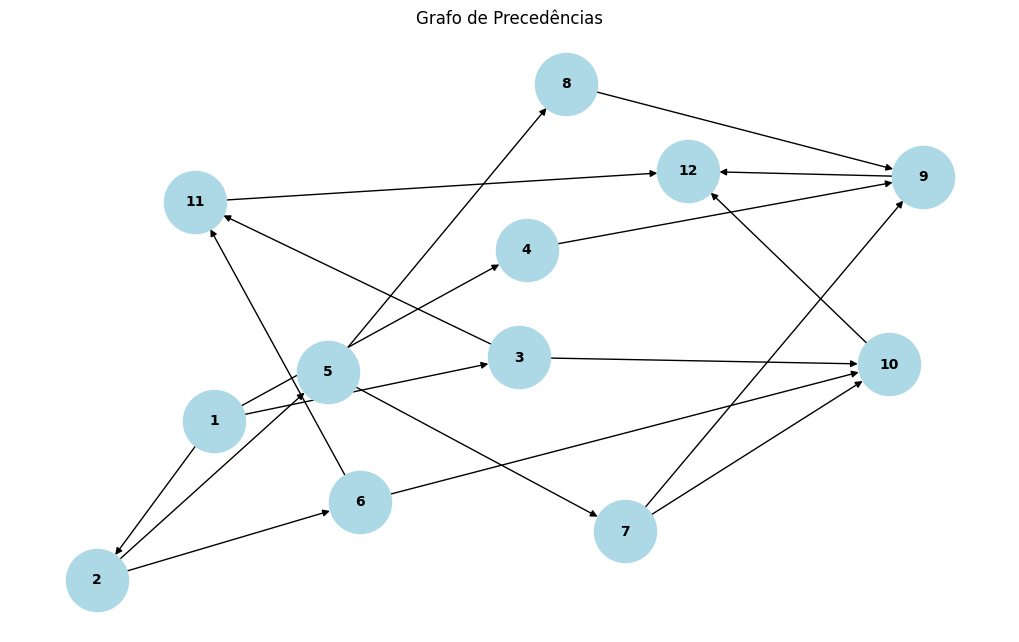

In [10]:
def create_precedence_graph(precedence_relations):
    # Criar o grafo direcionado
    G = nx.DiGraph()

    # Adicionar arestas com base nas relações de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            G.add_edge(task, successor)

    return G

# Criar o grafo a partir das relações de precedência
precedence_graph = create_precedence_graph(parsed_data["precedence_relations"])

# Visualizar o grafo
plt.figure(figsize=(10, 6))
nx.draw(precedence_graph, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight="bold")
plt.title("Grafo de Precedências")
plt.show()


2. **Modelar o Planeamento**:
   - Garantir que:
     - As precedências sejam respeitadas.
     - O uso de recursos seja limitado pela disponibilidade.
     - O cronograma esteja dentro do horizonte de tempo definido.

## Passo 4: Desenvolver o Planeador
### Escolher um algoritmo para criar o cronograma:
1. **Busca Heurística (ex.: A*)**:
   - Explora estados com base no tempo de conclusão estimado.
   - Dá prioridade às tarefas com menor tempo total estimado.

In [11]:
def initialize_schedule(horizon, resources):
    # Inicializar o cronograma com o horizonte de tempo e os recursos disponíveis
    schedule = {
        "time_slots": [0] * horizon,  # Horizonte de tempo
        "resource_usage": {r: [0] * horizon for r in resources.keys()}  # Uso de recursos
    }
    return schedule

# Inicializar o cronograma com base no horizonte e nos recursos
horizon = parsed_data["general_info"]["horizon"]
resources = parsed_data["resource_availability"]
schedule = initialize_schedule(horizon, resources)

print("Cronograma Inicial:")
print(json.dumps(schedule, indent=4))

Cronograma Inicial:
{
    "time_slots": [
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0
    ],
    "resource_usage": {
        "R1": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
 

2. **Programação Linear Inteira (ex.: OR-Tools)**:
   - Define restrições como:
     - Datas de início e fim das tarefas.
     - Disponibilidade de recursos em cada unidade de tempo.
     - Relações de precedência entre as tarefas.

In [12]:
def plan_tasks(precedence_relations, duration_and_resources, resource_availability, horizon):
    # Inicializar o cronograma
    schedule = initialize_schedule(horizon, resource_availability)

    # Dicionário para armazenar as tarefas planeadas
    planned_tasks = {}

    # Enquanto houver tarefas não planeadas
    while len(planned_tasks) < len(duration_and_resources):
        for task_info in duration_and_resources:
            task = task_info["task"]

            # Verificar se a tarefa já foi planeada
            if task in planned_tasks:
                continue

            # Verificar se todas as predecessoras já foram concluídas
            predecessors = [
                rel["task"]
                for rel in precedence_relations
                if task in rel["successors"]
            ]
            if any(pred not in planned_tasks for pred in predecessors):
                continue

            # Encontrar o primeiro intervalo de tempo disponível
            duration = task_info["duration"]
            resources_needed = task_info["resources"]
            start_time = None

            for t in range(horizon - duration):
                # Verificar se há recursos suficientes em todos os slots
                if all(
                    schedule["resource_usage"][r][t + i] + resources_needed[r] <= resource_availability[r]
                    for r in resources_needed
                    for i in range(duration)
                ):
                    start_time = t
                    break

            # Se for possível planear a tarefa, atualiza o cronograma
            if start_time is not None:
                for i in range(duration):
                    for r in resources_needed:
                        schedule["resource_usage"][r][start_time + i] += resources_needed[r]
                planned_tasks[task] = start_time

    return planned_tasks

# Planear as tarefas
planned_tasks = plan_tasks(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

print("Tarefas Planeadas:")
print(json.dumps(planned_tasks, indent=4))

Tarefas Planeadas:
{
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 3,
    "5": 3,
    "6": 7,
    "7": 3,
    "8": 11,
    "9": 15,
    "10": 11,
    "11": 15,
    "12": 0
}


## Passo 5: Implementar o Cronograma
1. **Alocar Recursos**:
   - Garante que os recursos não sejam excedidos em nenhuma unidade de tempo.
2. **Respeitar Precedências**:
   - Assegura que as tarefas sejam realizadas na ordem correta.
3. **Minimizar o Tempo Total (Makespan)**:
   - Optimiza o tempo total para concluir o projeto.

In [13]:
def validate_schedule(planned_tasks, precedence_relations):
    # Validar precedências
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            if planned_tasks[task] + parsed_data["duration_and_resources"][task - 1]["duration"] > planned_tasks[successor]:
                print(f"Erro: Precedência violada entre {task} -> {successor}")
                return False
    print("Validação: Todas as precedências foram respeitadas.")
    return True

# Validar o cronograma
validate_schedule(planned_tasks, parsed_data["precedence_relations"])


Erro: Precedência violada entre 5 -> 7


False

## Passo 6: Testar e Validar
1. **Validação**:
   - Verifica se o cronograma respeita todas as restrições (precedências, recursos e horizonte de tempo).
2. **Análise de Resultados**:
   - Avalia a eficiência do planeamento.

## Passo 7: Documentar o Processo
1. **Adicionar Explicações no Notebook**:
   - Descrever cada etapa realizada.
2. **Visualizações**:
   - Adicionar gráficos, tabelas e resultados finais para melhor interpretação.

In [14]:
def plan_tasks_with_heuristics(precedence_relations, duration_and_resources, resource_availability, horizon):
    # Inicializar o cronograma
    schedule = initialize_schedule(horizon, resource_availability)
    planned_tasks = {}  # Tarefas já planeadas

    while len(planned_tasks) < len(duration_and_resources):
        # Encontrar tarefas não planeadas cujas predecessoras foram concluídas
        available_tasks = []
        for task_info in duration_and_resources:
            task = task_info["task"]
            if task in planned_tasks:
                continue

            # Verificar se todas as predecessoras foram concluídas
            predecessors = [
                rel["task"]
                for rel in precedence_relations
                if task in rel["successors"]
            ]
            if all(pred in planned_tasks for pred in predecessors):
                # Calcula o tempo de término das predecessoras
                max_predecessor_end_time = max(
                    planned_tasks[pred] + next(
                        d["duration"] for d in duration_and_resources if d["task"] == pred
                    )
                    for pred in predecessors
                ) if predecessors else 0

                # Adicionar a tarefa à lista de disponíveis, incluindo a informação do tempo mínimo
                available_tasks.append((task_info, max_predecessor_end_time))

        # Ordenar as tarefas disponíveis pela heurística: menor duração e mais sucessoras
        available_tasks.sort(key=lambda t: (t[0]["duration"], -len([
            rel["successors"]
            for rel in precedence_relations
            if t[0]["task"] == rel["task"]
        ])))

        # Planear a primeira tarefa disponível que respeita os recursos
        for task_info, min_start_time in available_tasks:
            task = task_info["task"]
            duration = task_info["duration"]
            resources_needed = task_info["resources"]

            # Encontrar o primeiro intervalo de tempo disponível após as predecessoras
            start_time = None
            for t in range(min_start_time, horizon - duration + 1):
                if all(
                    schedule["resource_usage"][r][t + i] + resources_needed[r] <= resource_availability[r]
                    for r in resources_needed
                    for i in range(duration)
                ):
                    start_time = t
                    break

            # Se a tarefa pode ser planeada, atualiza o cronograma
            if start_time is not None:
                for i in range(duration):
                    for r in resources_needed:
                        schedule["resource_usage"][r][start_time + i] += resources_needed[r]
                planned_tasks[task] = start_time
                break

    return planned_tasks

# Planear as tarefas com a heurística
planned_tasks = plan_tasks_with_heuristics(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

print("Tarefas Planeadas (com heurística):")
print(json.dumps(planned_tasks, indent=4))

Tarefas Planeadas (com heurística):
{
    "1": 0,
    "3": 0,
    "2": 0,
    "5": 3,
    "6": 7,
    "8": 11,
    "11": 15,
    "7": 7,
    "10": 13,
    "4": 3,
    "9": 15,
    "12": 20
}


In [15]:
def validate_schedule_with_resources(planned_tasks, precedence_relations, duration_and_resources, resource_availability, horizon):
    # Validar precedências
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            task_end_time = planned_tasks[task] + next(
                d["duration"] for d in duration_and_resources if d["task"] == task
            )
            if task_end_time > planned_tasks[successor]:
                print(f"Erro: Precedência violada entre {task} -> {successor}")
                return False

    # Validar recursos
    schedule = initialize_schedule(horizon, resource_availability)
    for task, start_time in planned_tasks.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        for t in range(task_info["duration"]):
            for r in task_info["resources"]:
                schedule["resource_usage"][r][start_time + t] += task_info["resources"][r]
                if schedule["resource_usage"][r][start_time + t] > resource_availability[r]:
                    print(f"Erro: Recursos excedidos em Tarefa {task} no tempo {start_time + t}")
                    return False

    print("Validação: Todas as restrições foram respeitadas.")
    return True

# Validar o cronograma
validate_schedule_with_resources(
    planned_tasks,
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)


Validação: Todas as restrições foram respeitadas.


True

# Função para Criar o Gráfico de Gantt

In [ ]:
def plot_gantt_chart(planned_tasks, duration_and_resources):
    """
    Gera um gráfico de Gantt com base nas tarefas planeadas.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista de dicionários com duração e recursos de cada tarefa.
    """
    # Ordenar tarefas pelo tempo de início
    tasks = sorted(planned_tasks.keys(), key=lambda x: planned_tasks[x])
    start_times = [planned_tasks[task] for task in tasks]
    durations = [next(d["duration"] for d in duration_and_resources if d["task"] == task) for task in tasks]

    # Criar o gráfico de Gantt
    plt.figure(figsize=(10, 6))
    for i, task in enumerate(tasks):
        plt.barh(i, durations[i], left=start_times[i], color="skyblue", edgecolor="black")
        plt.text(
            start_times[i] + durations[i] / 2, i, f"T{task}", va="center", ha="center", color="black"
        )

    # Configurar o eixo
    plt.xlabel("Tempo")
    plt.ylabel("Tarefas")
    plt.title("Cronograma (Gráfico de Gantt)")
    plt.yticks(range(len(tasks)), [f"T{task}" for task in tasks])
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()


plot_gantt_chart(planned_tasks, parsed_data["duration_and_resources"])


# Análise do Makespan

In [ ]:
def calculate_makespan(planned_tasks, duration_and_resources):
    """
    Calcula o makespan (tempo total) com base nas tarefas planeadas.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista de dicionários com duração e recursos de cada tarefa.
    :return: Makespan (tempo total).
    """
    makespan = max(
        planned_tasks[task] + next(d["duration"] for d in duration_and_resources if d["task"] == task)
        for task in planned_tasks
    )
    return makespan

# Calcular o makespan
makespan = calculate_makespan(planned_tasks, parsed_data["duration_and_resources"])
print(f"Makespan (Tempo Total): {makespan}")


# Utilização de Recursos

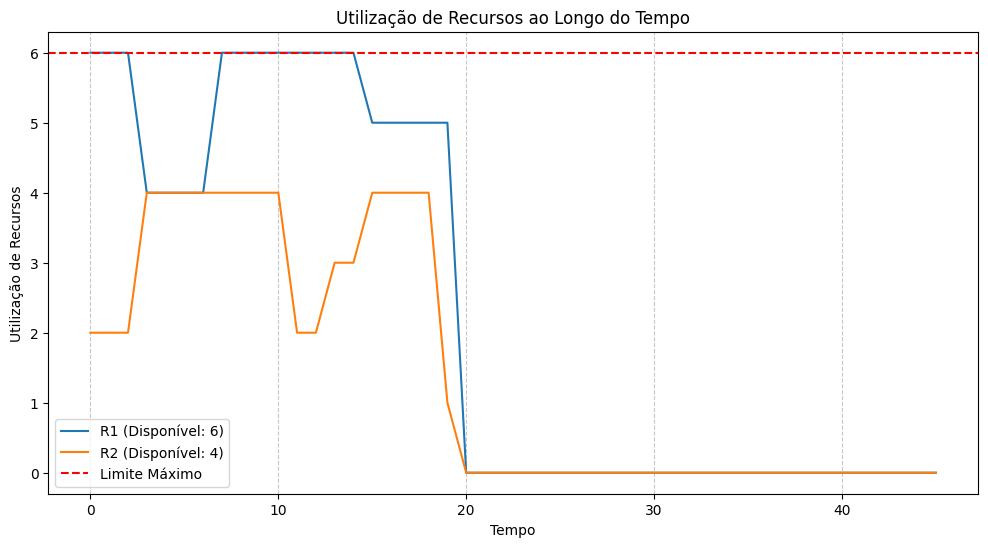

In [16]:
def plot_resource_usage(planned_tasks, duration_and_resources, resource_availability, horizon):
    """
    Gera um gráfico da utilização dos recursos ao longo do horizonte.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista com duração e recursos de cada tarefa.
    :param resource_availability: Dicionário com a disponibilidade total de recursos.
    :param horizon: Horizonte de tempo.
    """
    # Inicializar uso de recursos
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}

    # Preencher o uso de recursos
    for task, start_time in planned_tasks.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        duration = task_info["duration"]
        resources = task_info["resources"]
        for t in range(duration):
            for r, amount in resources.items():
                resource_usage[r][start_time + t] += amount

    # Plotar o uso de recursos
    plt.figure(figsize=(12, 6))
    for resource, usage in resource_usage.items():
        plt.plot(range(horizon), usage, label=f"{resource} (Disponível: {resource_availability[resource]})")

    plt.xlabel("Tempo")
    plt.ylabel("Utilização de Recursos")
    plt.title("Utilização de Recursos ao Longo do Tempo")
    plt.axhline(y=max(resource_availability.values()), color='r', linestyle='--', label="Limite Máximo")
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

# Gerar gráfico de utilização de recursos
plot_resource_usage(
    planned_tasks,
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)


# Plano para a Otimização
## Heurística Baseada no Caminho Crítico

In [ ]:
def calculate_critical_path(precedence_relations, duration_and_resources):
    """
    Calcula o caminho crítico do grafo de precedências.
    Retorna uma lista de tarefas no caminho crítico.
    """
    # Criar um dicionário de durações
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    
    # Criar um dicionário de sucessores
    successors = {rel["task"]: rel["successors"] for rel in precedence_relations}
    
    # Calcular o caminho crítico recursivamente
    critical_path = {}

    def calculate_path_length(task):
        if task in critical_path:
            return critical_path[task]
        if task not in successors or not successors[task]:
            critical_path[task] = durations[task]
        else:
            critical_path[task] = durations[task] + max(
                calculate_path_length(succ) for succ in successors[task]
            )
        return critical_path[task]

    # Calcular para todas as tarefas
    for task in durations:
        calculate_path_length(task)

    # Retornar tarefas ordenadas pelo comprimento do caminho crítico
    return sorted(critical_path, key=lambda x: -critical_path[x])

# Heurística: Priorizar tarefas no caminho crítico
def plan_tasks_critical_path(precedence_relations, duration_and_resources, resource_availability, horizon):
    critical_path = calculate_critical_path(precedence_relations, duration_and_resources)
    print("Caminho Crítico (ordem de tarefas):", critical_path)

    # Planeador ajustado
    return plan_tasks_with_heuristics(precedence_relations, duration_and_resources, resource_availability, horizon)

# Planear usando o caminho crítico
planned_tasks_critical = plan_tasks_critical_path(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

# Visualizar o cronograma otimizado
plot_gantt_chart(planned_tasks_critical, parsed_data["duration_and_resources"])


## Algoritmo A*

In [17]:
def a_star_scheduler(precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Algoritmo A* para planeamento de tarefas.
    """
    # Preparar dados
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    resources = {d["task"]: d["resources"] for d in duration_and_resources}
    successors = {rel["task"]: rel["successors"] for rel in precedence_relations}

    # Função de avaliação: custo + heurística
    def heuristic(state):
        remaining_tasks = set(durations.keys()) - set(state["completed_tasks"])
        return sum(durations[task] for task in remaining_tasks)  # Soma das durações restantes

    # Inicializar estado inicial
    initial_state = {
        "time": 0,
        "completed_tasks": [],
        "schedule": {},
        "resource_usage": {r: [0] * horizon for r in resource_availability}  # Recursos ao longo do tempo
    }

    # Fila de prioridade
    frontier = []
    heapq.heapify(frontier)
    counter = count()  # Contador para desempate

    # Adicionar o estado inicial
    heapq.heappush(frontier, (0, next(counter), initial_state))

    while frontier:
        # Retirar o estado com menor custo total
        _, _, current_state = heapq.heappop(frontier)

        # Verificar se é um estado final
        if len(current_state["completed_tasks"]) == len(durations):
            return current_state["schedule"]

        # Gerar próximos estados
        for task in durations.keys():
            if task in current_state["completed_tasks"]:
                continue

            # Verificar predecessoras
            predecessors = [
                pred for pred, rel in successors.items() if task in rel
            ]
            if any(pred not in current_state["completed_tasks"] for pred in predecessors):
                continue

            # Verificar disponibilidade de recursos
            start_time = max(
                max(
                    (current_state["schedule"].get(pred, 0) + durations[pred] for pred in predecessors if pred in current_state["schedule"]),
                    default=0
                ),
                current_state["time"]
            )

            duration = durations[task]
            resources_needed = resources[task]
            is_feasible = True

            # Verificar recursos ao longo da duração da tarefa
            for t in range(start_time, start_time + duration):
                if t >= horizon:
                    is_feasible = False
                    break
                for r, amount in resources_needed.items():
                    if current_state["resource_usage"][r][t] + amount > resource_availability[r]:
                        is_feasible = False
                        break
                if not is_feasible:
                    break

            if not is_feasible:
                continue

            # Gerar novo estado
            new_resource_usage = {
                r: usage.copy() for r, usage in current_state["resource_usage"].items()
            }
            for t in range(start_time, start_time + duration):
                for r, amount in resources_needed.items():
                    new_resource_usage[r][t] += amount

            new_state = {
                "time": start_time + duration,
                "completed_tasks": current_state["completed_tasks"] + [task],
                "schedule": {**current_state["schedule"], task: start_time},
                "resource_usage": new_resource_usage
            }

            # Calcular prioridade
            priority = new_state["time"] + heuristic(new_state)
            heapq.heappush(frontier, (priority, next(counter), new_state))

    return None  # Caso nenhuma solução seja encontrada

schedule_a_star = a_star_scheduler(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

print("Cronograma (A*):", schedule_a_star)

Cronograma (A*): {1: 0, 2: 0, 3: 3, 4: 4, 5: 12, 6: 16, 7: 20, 8: 26, 9: 30, 10: 35, 11: 42, 12: 46}


# Comparar Resultados

In [ ]:
# Comparar makespan
makespan_basic = calculate_makespan(planned_tasks, parsed_data["duration_and_resources"])
makespan_critical = calculate_makespan(planned_tasks_critical, parsed_data["duration_and_resources"])
makespan_a_star = calculate_makespan(schedule_a_star, parsed_data["duration_and_resources"])

print(f"Makespan (Básico): {makespan_basic}")
print(f"Makespan (Caminho Crítico): {makespan_critical}")
print(f"Makespan (A*): {makespan_a_star}")


In [ ]:
from constraint import Problem

def validate_schedule(schedule, precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Valida um cronograma gerado utilizando python-constraint.
    """
    # Criar o problema
    problem = Problem()

    # Adicionar variáveis com domínios fixos (os tempos gerados pelo algoritmo)
    for task, start_time in schedule.items():
        problem.addVariable(task, [start_time])

    # Adicionar restrições de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            def precedence_constraint(start_task, start_successor, task=task, successor=successor):
                duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
                return start_task + duration <= start_successor
            problem.addConstraint(precedence_constraint, (task, successor))

    # Adicionar restrições de recursos
    def resource_constraint(*start_times):
        resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
        for task, start_time in schedule.items():
            task_info = next(d for d in duration_and_resources if d["task"] == task)
            duration = task_info["duration"]
            resources_needed = task_info["resources"]
            for t in range(start_time, start_time + duration):
                for r, amount in resources_needed.items():
                    resource_usage[r][t] += amount
                    if resource_usage[r][t] > resource_availability[r]:
                        return False
        return True

    problem.addConstraint(resource_constraint, schedule.keys())

    # Validar a solução
    solution = problem.getSolution()
    return solution is not None

# Exemplo de uso
is_valid = validate_schedule(
    schedule=planned_tasks,  # Cronograma gerado pelo A*
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

if is_valid:
    print("Cronograma válido!")
else:
    print("Erro: Cronograma inválido!")


In [ ]:
def generate_schedule(precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Gera um cronograma válido utilizando python-constraint.
    """
    # Criar o problema
    problem = Problem()

    # Adicionar variáveis (tempo de início para cada tarefa)
    for task_info in duration_and_resources:
        task = task_info["task"]
        problem.addVariable(task, range(horizon))

    # Adicionar restrições de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            def precedence_constraint(start_task, start_successor, task=task, successor=successor):
                duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
                return start_task + duration <= start_successor
            problem.addConstraint(precedence_constraint, (task, successor))

    # Adicionar restrições de recursos
    def resource_constraint(*start_times):
        resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
        for task, start_time in enumerate(start_times, 1):
            task_info = next(d for d in duration_and_resources if d["task"] == task)
            duration = task_info["duration"]
            resources_needed = task_info["resources"]
            for t in range(start_time, start_time + duration):
                for r, amount in resources_needed.items():
                    resource_usage[r][t] += amount
                    if resource_usage[r][t] > resource_availability[r]:
                        return False
        return True

    problem.addConstraint(resource_constraint, [task_info["task"] for task_info in duration_and_resources])

    # Resolver o problema
    solution = problem.getSolution()

    if solution:
        return solution
    else:
        print("Nenhuma solução encontrada!")
        return None

# Exemplo de uso
generated_schedule = generate_schedule(
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

print("Novo cronograma gerado:")
print(generated_schedule)


In [ ]:
def calculate_makespan(schedule, duration_and_resources):
    """
    Calcula o makespan (tempo total) de um cronograma.
    """
    end_times = []
    for task, start_time in schedule.items():
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        end_times.append(start_time + duration)
    return max(end_times)

# Exemplo de uso
makespan_original = calculate_makespan(planned_tasks, parsed_data["duration_and_resources"])
makespan_generated = calculate_makespan(generated_schedule, parsed_data["duration_and_resources"])

print(f"Makespan Original: {makespan_original}")
print(f"Makespan Gerado: {makespan_generated}")


In [ ]:
import matplotlib.pyplot as plt

def plot_gantt_chart(schedule, duration_and_resources):
    """
    Plota um gráfico de Gantt com base no cronograma gerado.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for task, start_time in schedule.items():
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        ax.barh(task, duration, left=start_time, color='skyblue', edgecolor='black')
        ax.text(start_time + duration / 2, task, f"T{task}", va='center', ha='center', color='black')

    ax.set_xlabel("Tempo")
    ax.set_ylabel("Tarefas")
    ax.set_title("Gráfico de Gantt do Cronograma")
    plt.show()

# Exemplo de uso
plot_gantt_chart(generated_schedule, parsed_data["duration_and_resources"])


In [ ]:
import matplotlib.pyplot as plt
import random

def plot_gantt_chart(schedule, duration_and_resources):
    """
    Plota um gráfico de Gantt com diferentes cores para cada tarefa.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Gerar cores aleatórias para as tarefas
    colors = {task: (random.random(), random.random(), random.random()) for task in schedule.keys()}

    for task, start_time in schedule.items():
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        ax.barh(
            task, 
            duration, 
            left=start_time, 
            color=colors[task],  # Cor única para cada tarefa
            edgecolor="black"
        )
        ax.text(
            start_time + duration / 2, 
            task, 
            f"T{task}", 
            va='center', 
            ha='center', 
            color='white', 
            fontsize=10,
            weight="bold"
        )

    # Configurações do gráfico
    ax.set_xlabel("Tempo", fontsize=12)
    ax.set_ylabel("Tarefas", fontsize=12)
    ax.set_title("Gráfico de Gantt do Cronograma", fontsize=14)
    ax.set_yticks(list(schedule.keys()))
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
plot_gantt_chart(generated_schedule, parsed_data["duration_and_resources"])


In [ ]:
def validate_precedences(schedule, precedence_relations, duration_and_resources):
    """
    Valida se as restrições de precedência foram respeitadas no cronograma.
    """
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            task_end_time = schedule[task] + next(d["duration"] for d in duration_and_resources if d["task"] == task)
            if schedule[successor] < task_end_time:
                print(f"Erro: Precedência violada entre Tarefa {task} -> Tarefa {successor}")
                return False
    return True

# Exemplo de validação
is_precedences_valid = validate_precedences(
    schedule=generated_schedule,
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"]
)

print("Validação de Precedências:", "Válida" if is_precedences_valid else "Inválida")


In [ ]:
def validate_resources(schedule, duration_and_resources, resource_availability, horizon):
    """
    Valida se os recursos não foram excedidos em nenhuma unidade de tempo.
    """
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}

    for task, start_time in schedule.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        duration = task_info["duration"]
        resources_needed = task_info["resources"]

        for t in range(start_time, start_time + duration):
            if t >= horizon:
                print(f"Erro: Tarefa {task} excede o horizonte de tempo.")
                return False
            for r, amount in resources_needed.items():
                resource_usage[r][t] += amount
                if resource_usage[r][t] > resource_availability[r]:
                    print(f"Erro: Recurso {r} excedido no tempo {t} pela Tarefa {task}.")
                    return False
    return True

# Exemplo de validação
is_resources_valid = validate_resources(
    schedule=generated_schedule,
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

print("Validação de Recursos:", "Válida" if is_resources_valid else "Inválida")


In [ ]:
def validate_horizon(schedule, duration_and_resources, horizon):
    """
    Valida se o cronograma respeita o horizonte de tempo.
    """
    for task, start_time in schedule.items():
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        if start_time + duration > horizon:
            print(f"Erro: Tarefa {task} excede o horizonte de tempo.")
            return False
    return True

# Exemplo de validação
is_horizon_valid = validate_horizon(
    schedule=generated_schedule,
    duration_and_resources=parsed_data["duration_and_resources"],
    horizon=parsed_data["general_info"]["horizon"]
)

print("Validação do Horizonte:", "Válida" if is_horizon_valid else "Inválida")


# Conclusão

O desenvolvimento deste projeto permitiu aplicar conceitos fundamentais de Inteligência Artificial na criação e implementação de um agente inteligente. 
Durante este processo, foi possível explorar técnicas de planeamento, otimização e resolução de problemas sob restrições, consolidando conhecimentos teóricos e práticos.
Foi programado um agente inteligente capaz de lidar com restrições fortes, como precedência de tarefas e capacidade de recursos, e restrições leves, como a minimização da duração total do calendário (makespan).
Estas restrições foram integradas de maneira a criar um modelo realista e aplicável a cenários complexos.
Ao longo do processo, explorámos diversos tipos de soluções, desde soluções possíveis, que podem violar restrições, até soluções viáveis e otimizadas, que garantem o cumprimento das condições definidas.
O agente foi desenhado para encontrar soluções com pontuações elevadas dentro de um tempo limitado, demonstrando a capacidade de identificar a melhor solução encontrada e, quando possível, soluções ótimas.
